# Face detection using RetinaFace

---

In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from io import BytesIO
import base64
from retinaface import RetinaFace

In [ ]:
import findspark
findspark.init('/usr/lib/spark2')
from pyspark.sql import SparkSession

In [ ]:
os.environ['PYSPARK_SUBMIT_ARGS'] = ' --archives retina-env.zip#venv pyspark-shell'
os.environ['PYSPARK_PYTHON'] = 'venv/bin/python'

spark = (
    SparkSession.builder
    .appName('RetinaFace detection')
    .master('yarn')
    .config(
        'spark.driver.extraJavaOptions',
        ' '.join('-D{}={}'.format(k, v) for k, v in {
            'http.proxyHost': 'webproxy.eqiad.wmnet',
            'http.proxyPort': '8080',
            'https.proxyHost': 'webproxy.eqiad.wmnet',
            'https.proxyPort': '8080',
        }.items()))
    .config('spark.jars.packages', 'org.apache.spark:spark-avro_2.11:2.4.4')
    .config('spark.driver.memory', '4g') 
    .config('spark.dynamicAllocation.maxExecutors', 128) 
    .config('spark.executor.memory', '8g') 
    .config('spark.executor.cores', 4) 
    .config('spark.sql.shuffle.partitions', 512)
    .config('spark.sql.execution.arrow.maxRecordsPerBatch', 1024)
    .getOrCreate()
)

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.types import StringType

#### Load the data into Spark DataFrames

In [ ]:
pixels = spark.read.format('avro').load('image.avro')

In [ ]:
pixels.printSchema()

root
 |-- i: integer (nullable = true)
 |-- image_url: string (nullable = true)
 |-- project: string (nullable = true)
 |-- image_file_name: string (nullable = true)
 |-- thumbnail_size: string (nullable = true)
 |-- image: struct (nullable = true)
 |    |-- image_bytes_b64: string (nullable = true)
 |    |-- format: string (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- image_bytes_sha1: string (nullable = true)
 |    |-- error: string (nullable = true)



#### Define a Pandas udf to detect faces

In [ ]:
@F.pandas_udf(returnType=StringType())
def detect_face(image_bytes):
    ret = []
    detector = RetinaFace(quality='normal')
    for row in image_bytes:
        try:
            img = Image.open(BytesIO(base64.b64decode(row))).convert('RGB')
            img = np.asarray(img, dtype=np.float32)
            area = img.shape[0]*img.shape[1]
            faces = detector.predict(img)
            boxes=[]
            for face in faces:
                box=(face['x2']-face['x1'])*(face['y2']-face['y1'])
                areapercentage=box/float(area)
                boxes.append(areapercentage)
        except:
            ret.append(str({'count':-1,'max':-1,'sum':-1}))
        else:
            ret.append(str({'count':len(faces),'max':max(boxes),'sum':sum(boxes)})) if len(faces) else ret.append(None)
    return pd.Series(ret)

#### Run model inference and save results to Hive

In [ ]:
(pixels
    .withColumn('faces', detect_face(F.col('image.image_bytes_b64')))
    .withColumn(
                'data',
                F.explode(
                    F.from_json('faces', 'array<struct<count:int,max:double,sum:double>>')
                ),
    )
    .select('i','image_file_name','data.count','data.max','data.sum','image_url')
    .coalesce(1)
    .write
    .mode('overwrite')
    .option('path', 'retinaface')
    .saveAsTable('aikochou.retinaface')
)

In [ ]:
result = spark.read.parquet('retinaface')
result.count()

26

#### Display result

In [ ]:
from IPython.core.display import display, HTML

In [ ]:
@F.udf(returnType=StringType())
def html_image(img_b64):
    return '<img src="data:image/png;base64,{0:s}">'.format(img_b64)

,image_file_name,count,max,sum,thumbnail
0,DM_Rad_2017_Männer_Ziel_02_Marcus_Burghardt_Emanuel_Buchmann.jpg,5,0.002826,0.007241,
1,Jackie_Chan_TIFF_2005.jpg,1,0.053880,0.053880,
2,Waltraud_Starck_2018_01-22.jpg,1,0.204000,0.204000,
3,RAMON_FRANCO_AÑO_1926.JPG,1,0.100822,0.100822,
4,Antonio_Zamorano.jpg,1,0.303933,0.303933,
5,Tony_Kushner_-_Hollywood_and_Socialism_-_The_Laura_Flanders_Show_2.png,1,0.161905,0.161905,
6,Iturbide_NL_Techo_de_Tabletas.jpg,2,0.001185,0.002015,
7,Northern_Ireland_vs_Czechoslovakia_FIFA_World_Cup_1958.jpg,3,0.002383,0.005367,
8,The_Wedding_of_Satyabhama_and_Krishna_from_Bhagavata_Purana.jpg,2,0.001789,0.003545,
9,StateLibQld_1_112328_Charles_Borromeo_Fitzgerald.jpg,1,0.220312,0.220312,

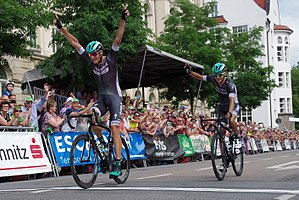
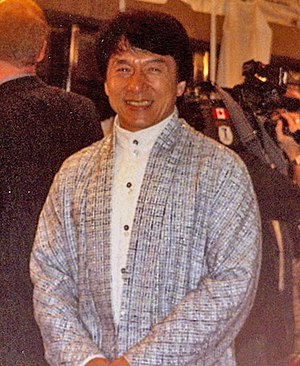
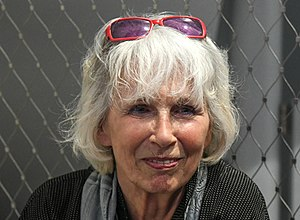
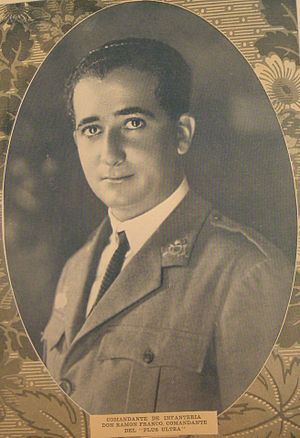
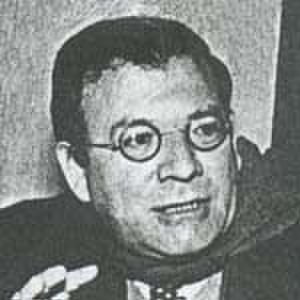
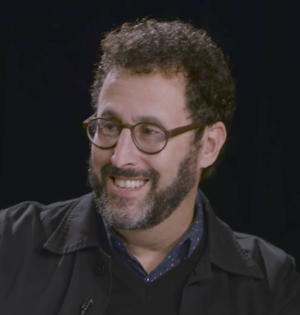
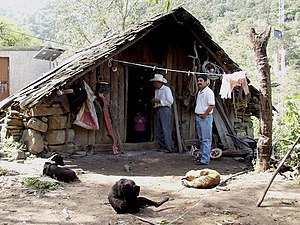
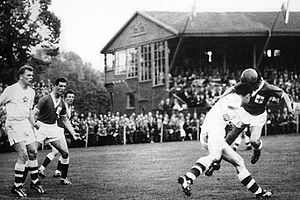
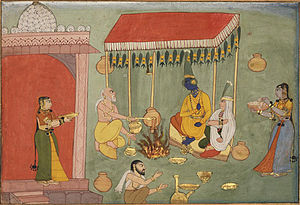
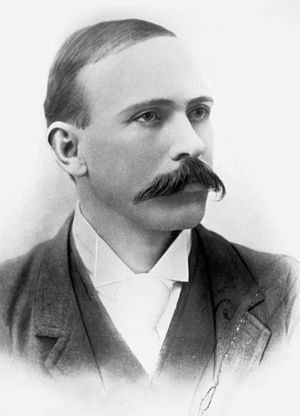
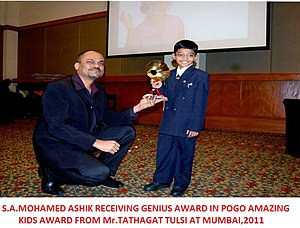
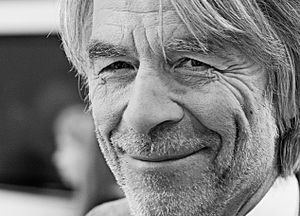
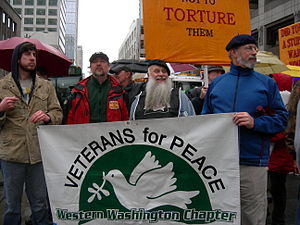
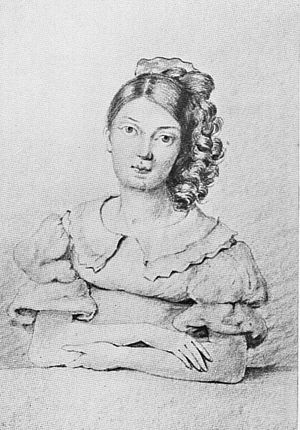
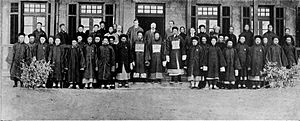
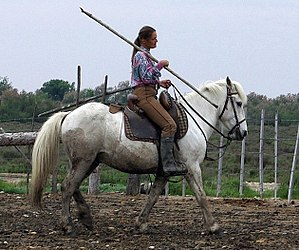
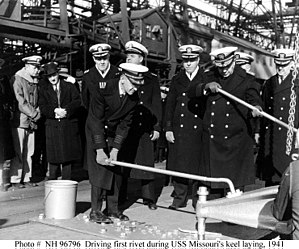
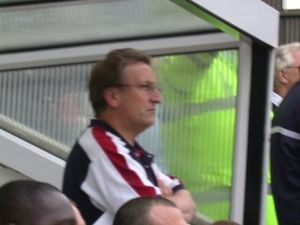
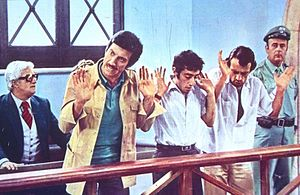
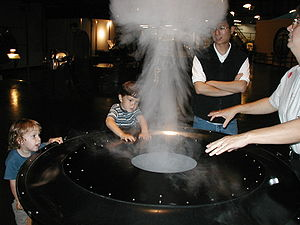
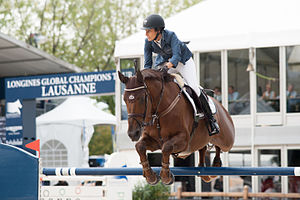
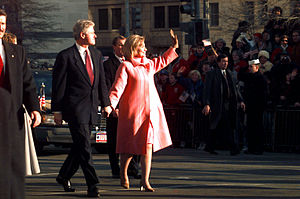
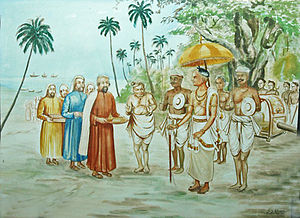
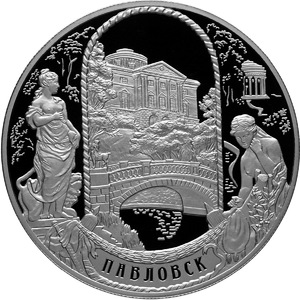
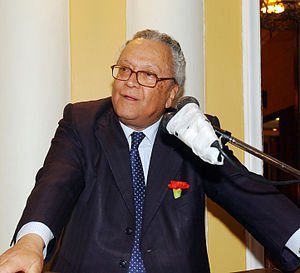
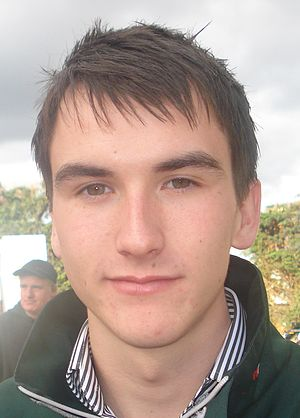

In [ ]:
html_all = (pixels
   .withColumn('faces', detect_face(F.col('image.image_bytes_b64')))
   .withColumn('thumbnail', html_image(F.col('image.image_bytes_b64')))
   .withColumn(
                "data",
                F.explode(
                    F.from_json('faces', 'array<struct<count:int,max:double,sum:double>>')
                ),
    )
   .select('image_file_name','data.count','data.max','data.sum','thumbnail')
   .toPandas()
   .to_html(escape=False)
)

display(HTML(html_all))